Suorce is question-answer pair and target is a set of distractors( varies from 1 to 3).
Approch: I will consider both the sources and will take one distractor as target. For tokenizing I am doing from scratch using pandas, lamda function and dictionary. My model will be a encoder-decoder model.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/mcq-distractors/Train.csv
/kaggle/input/mcq-distractors/Test.csv


In [2]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import string
import re
import tensorflow as tf
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, Concatenate, Bidirectional, Dense, Activation
from keras.models import Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
data = pd.read_csv('/kaggle/input/mcq-distractors/Train.csv').iloc[:,:3]
print(data.head())

                                            question  \
0                                Meals can be served   
1           It can be inferred from the passage that   
2     The author called Tommy 's parents in order to   
3           It can be inferred from the passage that   
4  How can we deal with snake wounds according to...   

                                         answer_text  \
0                             in rooms at 9:00 p. m.   
1  The local government can deal with the problem...   
2         help them realize their influence on Tommy   
3       the writer is not very willing to use idioms   
4                        Stay calm and do n't move .   

                                          distractor  
0                   'outside the room at 3:00 p. m.'  
1                   'If some tragedies occur again '  
2               'blame Tommy for his failing grades'  
3  'idioms are the most important part in a langu...  
4          'Cut the wound and suck the poison out .

In [4]:
# drop duplicates

data.drop_duplicates(inplace=True)

In [5]:
# remove quotes

data['question'] = data['question'].apply(lambda x: re.sub("'", '', x))
data['answer_text'] = data['answer_text'].apply(lambda x: re.sub("'", '', x))
data['distractor'] = data['distractor'].apply(lambda x: re.sub("'", '', x))
print(data.head())

                                            question  \
0                                Meals can be served   
1           It can be inferred from the passage that   
2      The author called Tommy s parents in order to   
3           It can be inferred from the passage that   
4  How can we deal with snake wounds according to...   

                                         answer_text  \
0                             in rooms at 9:00 p. m.   
1  The local government can deal with the problem...   
2         help them realize their influence on Tommy   
3       the writer is not very willing to use idioms   
4                         Stay calm and do nt move .   

                                         distractor  
0                    outside the room at 3:00 p. m.  
1                    If some tragedies occur again   
2                blame Tommy for his failing grades  
3  idioms are the most important part in a language  
4           Cut the wound and suck the poison out .  


In [6]:
# filter long texts

data['question_len'] = data['question'].apply(lambda x: len(x.split()))
data['answer_len'] = data['answer_text'].apply(lambda x: len(x.split()))
data['distractor_len'] = data['distractor'].apply(lambda x: len(x.split()))
print(len(data))
data = data[data['question_len']<=25]
data = data[data['answer_len']<=25]
data = data[data['distractor_len']<=25]
print(len(data))

# max question and answer length
max_question_len = 25
max_ans_len = 25 
max_dis_len = 26 # i will add START_ and _END # decoder input will have the START_ tokens and decoder output will have the _END

31499
31419


In [7]:
# convert to lower 

data['question'] = data['question'].apply(lambda x: x.lower())
data['answer_text'] = data['answer_text'].apply(lambda x: x.lower())
data['distractor'] = data['distractor'].apply(lambda x: x.lower())
print(data.head())

                                            question  \
0                                meals can be served   
1           it can be inferred from the passage that   
2      the author called tommy s parents in order to   
3           it can be inferred from the passage that   
4  how can we deal with snake wounds according to...   

                                         answer_text  \
0                             in rooms at 9:00 p. m.   
1  the local government can deal with the problem...   
2         help them realize their influence on tommy   
3       the writer is not very willing to use idioms   
4                         stay calm and do nt move .   

                                         distractor  question_len  answer_len  \
0                    outside the room at 3:00 p. m.             4           6   
1                    if some tragedies occur again              8          15   
2                blame tommy for his failing grades             9           7   
3 

In [8]:
# exclude special characters

special_char = string.punctuation
data['question'] = data['question'].apply(lambda x: ''.join(ch for ch in x if ch not in special_char))
data['answer_text'] = data['answer_text'].apply(lambda x: ''.join(ch for ch in x if ch not in special_char))
data['distractor'] = data['distractor'].apply(lambda x: ''.join(ch for ch in x if ch not in special_char))
print(data.head())

                                            question  \
0                                meals can be served   
1           it can be inferred from the passage that   
2      the author called tommy s parents in order to   
3           it can be inferred from the passage that   
4  how can we deal with snake wounds according to...   

                                         answer_text  \
0                                in rooms at 900 p m   
1  the local government can deal with the problem...   
2         help them realize their influence on tommy   
3       the writer is not very willing to use idioms   
4                          stay calm and do nt move    

                                         distractor  question_len  answer_len  \
0                       outside the room at 300 p m             4           6   
1                    if some tragedies occur again              8          15   
2                blame tommy for his failing grades             9           7   
3 

In [9]:
# add START_ and _END tokens

data['distractor'] = data['distractor'].apply(lambda x: 'START_ '+x+' _END')
print(data.head())

                                            question  \
0                                meals can be served   
1           it can be inferred from the passage that   
2      the author called tommy s parents in order to   
3           it can be inferred from the passage that   
4  how can we deal with snake wounds according to...   

                                         answer_text  \
0                                in rooms at 900 p m   
1  the local government can deal with the problem...   
2         help them realize their influence on tommy   
3       the writer is not very willing to use idioms   
4                          stay calm and do nt move    

                                          distractor  question_len  \
0            START_ outside the room at 300 p m _END             4   
1         START_ if some tragedies occur again  _END             8   
2     START_ blame tommy for his failing grades _END             9   
3  START_ idioms are the most important part i

In [10]:
# creating question and answer vocabulary
all_question_words = []
for i in data['question']:
    all_question_words += i.split()

all_question_words = list(set(all_question_words))

all_ans_words = []
for i in data['answer_text']:
    all_ans_words += i.split()
    
all_ans_words = list(set(all_ans_words))

all_dis_words = []
for i in data['distractor']:
    all_dis_words += i.split()
    
all_dis_words = list(set(all_dis_words))

In [11]:
source_words = sorted(list(set(all_question_words +all_ans_words)))
target_words = sorted(all_dis_words)

num_source_tokens = len(source_words)
num_target_tokens = len(target_words)


In [12]:
# tokenizing words

source_tokens = dict([(word, i+1) for i, word in enumerate(source_words)])
target_tokens = dict([(word, i+1) for i, word in enumerate(target_words)])

In [13]:
# reverse tokenizing

reverse_source_tokens = dict([(i,word) for word, i in source_tokens.items()])
reverse_target_tokens = dict([(i,word) for word, i in target_tokens.items()])


In [14]:
# train and test data 

source1, source2, target = data['question'], data['answer_text'], data['distractor']
source1_train, source1_test, source2_train, source2_test, target_train, target_test = train_test_split(source1, source2, target, test_size=0.2, random_state=21)

In [15]:
# function to generate batches as the entire data is to large to store at once. 
def generate_batch(X1, X2, y, batch_size=64):
    while True:
        for b in range(0, len(X1), batch_size):
            encoder_source1_train = np.zeros((batch_size, max_question_len), dtype='float32')
            encoder_source2_train = np.zeros((batch_size, max_ans_len), dtype='float32')
            decoder_source_train = np.zeros((batch_size, max_dis_len), dtype='float32')
            decoder_target_train = np.zeros((batch_size, max_dis_len, num_target_tokens))
            for i, (source1_text, source2_text, target_text) in enumerate(zip(X1[b:b+batch_size], X2[b:b+batch_size], y[b:b+batch_size])):
                for t, word in enumerate(source1_text.split()):
                    encoder_source1_train[i, t] = source_tokens[word]
                for t, word in enumerate(source2_text.split()):
                    encoder_source2_train[i, t] = source_tokens[word]
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_source_train[i, t] = target_tokens[word]
                    if t>0:
                        decoder_target_train[i, t-1, target_tokens[word]-1] = 1
            yield ([encoder_source1_train, encoder_source2_train, decoder_source_train], decoder_target_train)
 

Encoder-Decoder network

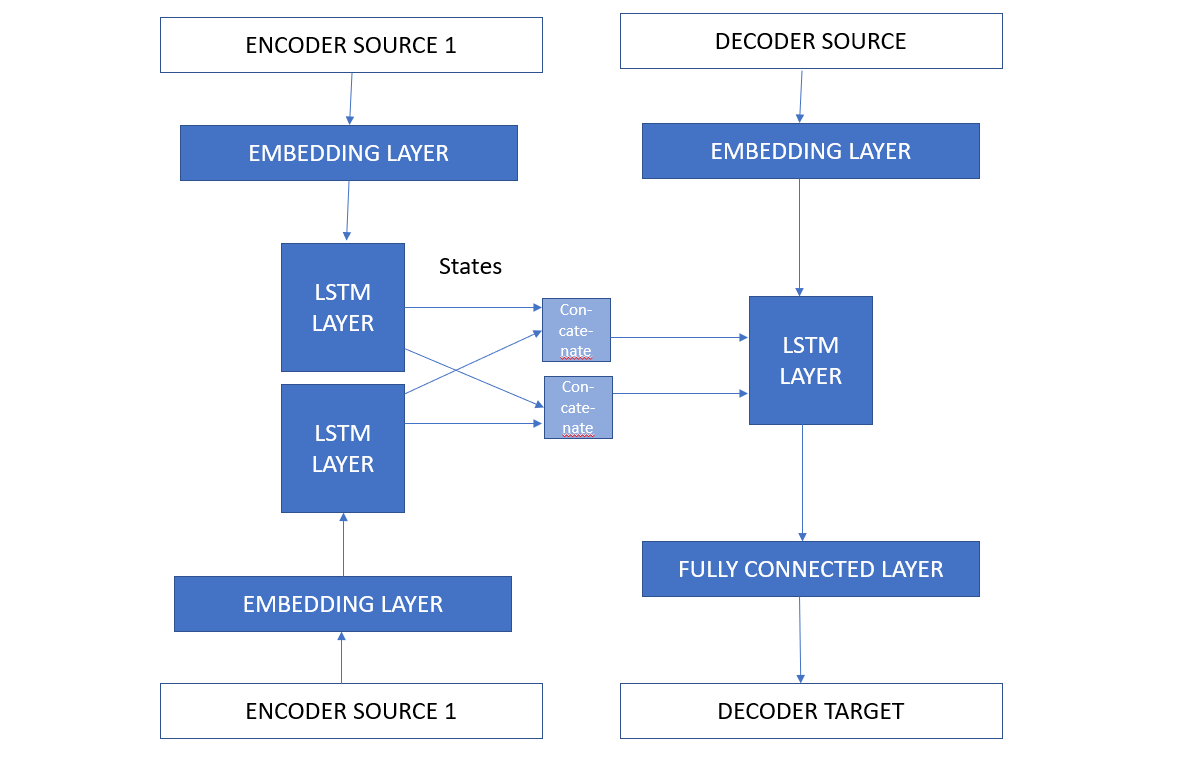

In [16]:
latent_dim = 300

# encoder
encoder_input1 = Input(shape=(None,))
encoder_input2 = Input(shape=(None,))
encoder_embedding = Embedding(num_source_tokens, latent_dim, mask_zero=True)
source1_encoded_embedding = encoder_embedding(encoder_input1)
source2_encoded_embedding = encoder_embedding(encoder_input2)
encoder_LSTM = LSTM(latent_dim, return_state = True)
source1_encoder_outputs, source1_state_h, source1_state_c = encoder_LSTM(source1_encoded_embedding)
source2_encoder_outputs, source2_state_h, source2_state_c = encoder_LSTM(source2_encoded_embedding)
source_h_state = Concatenate(axis=-1)([source1_state_h, source2_state_h])
source_c_state = Concatenate(axis=-1)([source1_state_c, source2_state_c])
encoder_state = [source_h_state, source_c_state]

In [17]:
# decoder

decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(num_target_tokens, latent_dim, mask_zero=True)
decoded_embedding = decoder_embedding(decoder_input)
decoder_LSTM = LSTM(600, return_state=True, return_sequences=True)
decoder_output, _, _ = decoder_LSTM(decoded_embedding, initial_state = encoder_state)
decoder_dense = Dense(num_target_tokens, activation='softmax')
decoder_output = decoder_dense(decoder_output)

In [18]:
model = Model([encoder_input1, encoder_input2, decoder_input], decoder_output)
print(model.summary())
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    5685300     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                      

In [19]:
#traing model
model.fit_generator(generator=generate_batch(source1_train, source2_train, target_train, batch_size=64),steps_per_epoch = len(source1_train)//64, validation_data=generate_batch(source1_test, source2_test, target_test, batch_size=64), validation_steps=len(source1_test)//64, epochs = 25)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
392/392 [==============================] - 100s 256ms/step - loss: 1.9092 - val_loss: 1.7937
Epoch 2/25
392/392 [==============================] - 98s 249ms/step - loss: 1.6986 - val_loss: 1.5075
Epoch 3/25
392/392 [==============================] - 98s 249ms/step - loss: 1.5958 - val_loss: 1.5084
Epoch 4/25
392/392 [==============================] - 99s 252ms/step - loss: 1.5160 - val_loss: 1.7533
Epoch 5/25
392/392 [==============================] - 98s 250ms/step - loss: 1.4431 - val_loss: 1.5938
Epoch 6/25
392/392 [==============================] - 98s 249ms/step - loss: 1.3696 - val_loss: 1.7246
Epoch 7/25
392/392 [==============================] - 98s 251ms/step - loss: 1.2979 - val_loss: 1.6272
Epoch 8/25
392/392 [==============================] - 97s 249ms/step - loss: 1.2266 - val_loss: 1.7392
Epoch 9/25
392/392 [==============================] - 98s 249ms/step - loss: 1.1553 - val_loss: 1.6247
Epoch 10/25
392/392 [==============================] - 98s 251ms/step - 

In [20]:
len(target_tokens)

13566